<a href="https://colab.research.google.com/github/gaoqisheng123-bot/machine-learning-zoomcamp-homework/blob/main/machine_learning_zoomcamp_homework_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [57]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-19 14:02:17--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.1’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.002s  

2025-10-19 14:02:17 (37.5 MB/s) - ‘course_lead_scoring.csv.1’ saved [80876/80876]



In [58]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [59]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_columns:
    df[c] = df[c].fillna('NA')

numerical_columns = list(df.select_dtypes(include=['number']).columns)
for n in numerical_columns:
    df[n] = df[n].fillna(0.0)

print(df.isnull().sum())

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [60]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Train: {len(df_train)}")
print(f"Validation: {len(df_val)}")
print(f"Test: {len(df_test)}")

Train: 876
Validation: 293
Test: 293


In [61]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [62]:
from sklearn.metrics import roc_auc_score

In [63]:
#1
numerical_cols = df_train.select_dtypes(include=['number']).columns


auc_scores = {}

for feature in numerical_cols:
    auc_score = roc_auc_score(y_train, df_train[feature])
    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -df_train[feature])
        print(f"Inverted {feature} (original AUC < 0.5)")

    auc_scores[feature] = auc_score

for f, a in auc_scores.items():
    print(f"{f}: {a:.4f}")

number_of_courses_viewed: 0.7636
annual_income: 0.5520
interaction_count: 0.7383
lead_score: 0.6145


In [64]:
#2
target = 'converted'
categorical_columns = [c for c in categorical_columns if c != target]
numerical_columns = [c for c in numerical_columns if c != target]

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_pred)
print(f"Validation AUC: {auc_val:.3f}")


Validation AUC: 0.817


In [65]:
from sklearn.metrics import precision_score, recall_score

/tmp/ipython-input-466274578.py:17: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


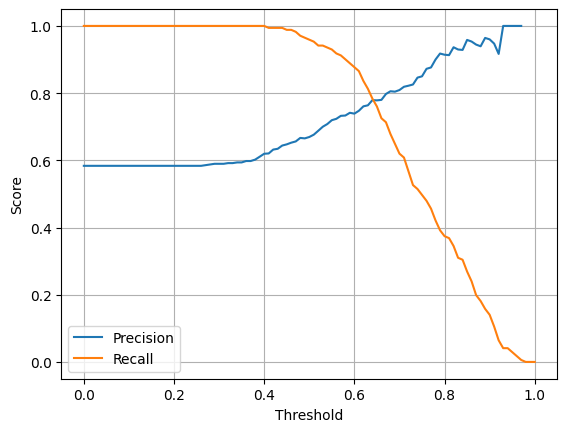

0.64


In [66]:
#3
thresholds = np.linspace(0, 1.0, 101)
scores = []

for t in thresholds:

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    scores.append((t, tp, fp, fn, tn, p, r))


columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'Precision', 'Recall']
df_scores = pd. DataFrame(scores, columns = columns)

plt.plot(df_scores.threshold, df_scores.Precision, label='Precision')
plt.plot(df_scores.threshold, df_scores.Recall, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

diff = np.abs(df_scores.Precision - df_scores.Recall)
idx = diff.idxmin()

intersection = df_scores.loc[idx, 'threshold']
print(intersection)


In [67]:
#4
df_scores['f1'] = 2 * df_scores.Precision * df_scores.Recall / (df_scores.Precision + df_scores.Recall)

best_idx = np.argmax(df_scores['f1'])
best_threshold = thresholds[best_idx]
best_f1 = df_scores['f1'][best_idx]

print(f"Best F1 = {best_f1} at threshold {best_threshold}")

Best F1 = 0.8124999999999999 at threshold 0.5700000000000001


In [70]:
from sklearn.model_selection import KFold

In [77]:
#5
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C= C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model


def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


kfold = KFold(n_splits= 5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C= 1.0)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

print(f"Standard deviation = {np.std(scores):.3f}")

Standard deviation = 0.036


In [78]:
from tqdm.auto import tqdm

In [81]:
#6

n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f"C = {C}, mean = {np.mean(scores)}")

  0%|          | 0/3 [00:00<?, ?it/s]

C = 1e-06, mean = 0.560207852870275
C = 0.001, mean = 0.8668780317675395
C = 1, mean = 0.8221089148573075
